In [2]:
import copy
import math
import torch
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from gamesopt.train_distributed import train, TrainConfig
from gamesopt.games import GameOptions, QuadraticGameConfig, GameType
from gamesopt.optimizer.base import OptimizerOptions, OptimizerType
from gamesopt.aggregator import AggregationOptions, AggregatorType
from gamesopt.attacks import AttackOptions, AttackType
from gamesopt.games.utils import create_matrix

%matplotlib widget
%load_ext autoreload
%autoreload 1

In [3]:
labels = list(OptimizerType)
labels = [i.name for i in labels]
colors = {labels[i] : list(mcolors.TABLEAU_COLORS.keys())[i] for i in range(0, len(OptimizerType))}

In [94]:
n_iter = 6001

n_peers = 20
n_byzan = 4

num_samples = 1000
dim = 16
with_bias = True
sigma = 1  # actually scales sigma
mu = 1e-1
ell = 1e3

attack_type = AttackType.IPM
n_attacking = 1
ipm_epsilon = 1e-1 # 0.1
rn_sigma = 1e3
alie_z = 1e-1# 1.06

use_bucketing = True
bucketing_s = 2
aggregator_type = AggregatorType.RFA
trimmed_mean_b = 10
krum_m = 2
clipping_tau = 10
clipping_n_iter = 3
rfa_T: int = 10
rfa_nu: int = 0.1

optimizer_type = OptimizerType.SGDARA
# optimizer_type = OptimizerType.MSGDARA
# optimizer_type = OptimizerType.SEGDARA
alpha = 0.1
lr = 1/2/ell/15
lr_inner = lr
lr_outer = lr
sigmaC = 100.

batch_size = 100

In [95]:
matrix, bias = create_matrix(dim, num_samples, mu, ell, sigma,
                             with_bias=with_bias)
true = torch.linalg.solve(matrix.mean(dim=0), -bias.mean(dim=0))
players = true + .1/math.sqrt(2.*dim)

In [96]:
aggregation_options = AggregationOptions(n_peers=n_peers,
                                         n_byzan=n_byzan,
                                         aggregator_type=aggregator_type,
                                         use_bucketing=use_bucketing,
                                         bucketing_s=bucketing_s,
                                         trimmed_mean_b=trimmed_mean_b,
                                         krum_m=krum_m,
                                         clipping_tau=clipping_tau,
                                         clipping_n_iter=clipping_n_iter,
                                         rfa_T=rfa_T,
                                         rfa_nu=rfa_nu)

quadratic_game_options = QuadraticGameConfig(num_samples=num_samples,
                                             dim=dim,
                                             num_players=2,
                                             with_bias=with_bias,
                                             sigma=sigma,
                                             mu=mu,
                                             ell=ell,
                                             matrix=matrix,
                                             bias=bias,
                                             players=players,
                                             true=true)

game_options = GameOptions(GameType.QUADRATIC, quadratic_game_options)

attack_options = AttackOptions(n_peers=n_peers,
                               n_byzan=n_byzan,
                               n_attacking=n_attacking,
                               attack_type=attack_type,
                               ipm_epsilon=ipm_epsilon,
                               rn_sigma=rn_sigma,
                               alie_z=alie_z)

optimizer_options = OptimizerOptions(n_peers=n_peers,
                                     optimizer_type=optimizer_type,
                                     lr=lr,
                                     batch_size=batch_size,
                                     aggregation_options=aggregation_options,
                                     attack_options=attack_options,
                                     sigmaC=sigmaC,
                                     alpha=alpha,
                                     lr_inner=lr_inner,
                                     lr_outer=lr_outer)
base_config = TrainConfig(n_iter, n_peers, game_options, optimizer_options)

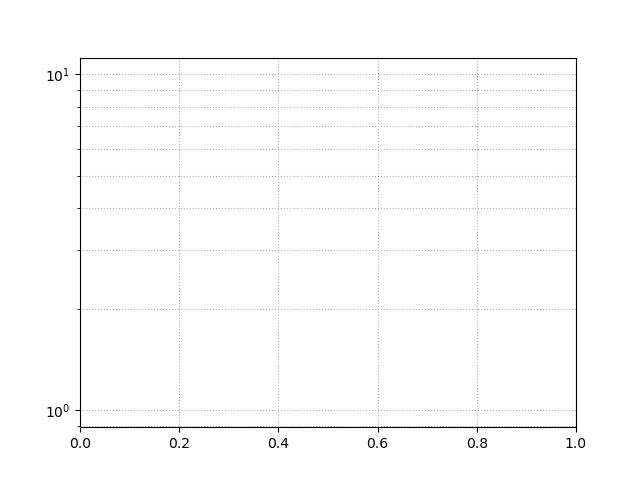

In [97]:
plt.figure()
plt.yscale('log')
plt.grid(True, which="both", ls='dotted')

In [98]:
config = copy.deepcopy(base_config)
config.optimizer.optimizer_type = OptimizerType.MSGDARA
config.optimizer.attack_options.n_attacking = n_byzan
config.optimizer.alpha = 0.1
record = train(config)
record.load_metrics()
plt.plot(record.metrics.num_grad, record.metrics.dist, alpha=0.5,
         color=colors[config.optimizer.optimizer_type.name],
         marker=config.optimizer.optimizer_type.value, markevery=10,
         label="%s (%.1f)" % (config.optimizer.optimizer_type.name, config.optimizer.alpha))
plt.legend()
xmax = record.metrics.num_grad[-1]

Trying port 39512


In [99]:
config = copy.deepcopy(base_config)
config.optimizer.optimizer_type = OptimizerType.SGDACC
config.optimizer.attack_options.n_attacking = 1
record = train(config)
record.load_metrics()
plt.plot(record.metrics.num_grad, record.metrics.dist,alpha=0.5,
         color=colors[config.optimizer.optimizer_type.name],
         marker=config.optimizer.optimizer_type.value, markevery=10,
         label="%s" % config.optimizer.optimizer_type.name)
plt.legend()
xmax = min(record.metrics.num_grad[-1], xmax)

Trying port 31159


In [100]:
config = copy.deepcopy(base_config)
config.optimizer.optimizer_type = OptimizerType.SEGCC
config.optimizer.attack_options.n_attacking = 1
config.num_iter = int(config.num_iter / 2) + 1
record = train(config)
record.load_metrics()
plt.plot(record.metrics.num_grad, record.metrics.dist,alpha=0.5,
         color=colors[config.optimizer.optimizer_type.name],
         marker=config.optimizer.optimizer_type.value, markevery=10,
         label="%s" % config.optimizer.optimizer_type.name)
plt.legend()
xmax = min(record.metrics.num_grad[-1], xmax)

Trying port 16731


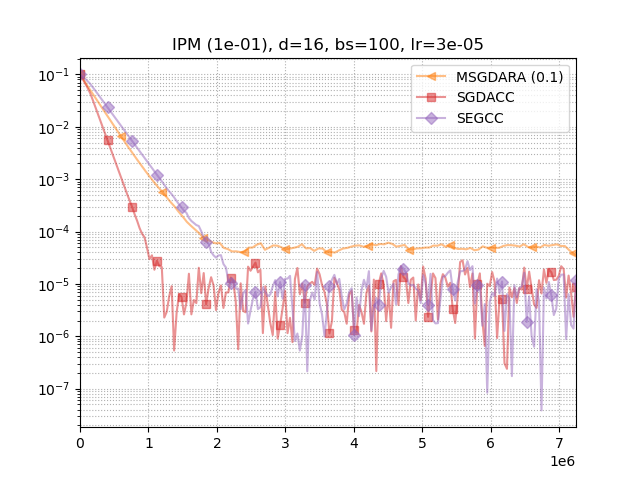

In [101]:
title = base_config.optimizer.attack_options.attack_type.name
if base_config.optimizer.attack_options.attack_type == AttackType.ALIE:
    title += " (%.e)" % base_config.optimizer.attack_options.alie_z
elif base_config.optimizer.attack_options.attack_type == AttackType.RN:
    title += " (%.e)" % base_config.optimizer.attack_options.rn_sigma
elif base_config.optimizer.attack_options.attack_type == AttackType.IPM:
    title += " (%.e)" % base_config.optimizer.attack_options.ipm_epsilon
title += ", d=%i" % base_config.game.quadratic_options.dim
# title += ", na=%i" % base_config.optimizer.attack_options.n_attacking
title += ", bs=%i" % base_config.optimizer.batch_size
title += ", lr=%.e" % base_config.optimizer.lr
plt.xlim(0, xmax)
plt.title(title)
plt.yscale('log')
plt.xscale('linear')
plt.grid(True, which="both", ls='dotted')
plt.legend()
plt.show()

In [102]:
plt.savefig('figures/RAvsCC/'+title+'.pdf', bbox_inches='tight')